In [25]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import os

def parsing(file):

    # data loading
    df = pd.read_csv(file)

    # split 구분
    df['<XMLData>'] = df['<XMLData>'].apply(lambda x : re.split('[><]', x))

    # Data Frame 만들기 - 131개 기준으로 protocol 구분
    df['head'] = df['<XMLData>'].str.get(1)
    df['value'] = df['<XMLData>'].str.get(2)
    df = df.iloc[:, 1:3]

    df = df.T
    df = df.rename(columns=df.iloc[0])
    df = df.drop(['head'])

    
    # 첫 행
    x=0
    y=132
    x_0 = df.iloc[:,x:y]

    # 2~마지막 행 구해서 붙이기
    xx = []
    for j in range(1,88):
        x = y
        y=y+132
        z=y
        x_j = df.iloc[:,x:z]
        xx.append(x_j)

    xx = pd.concat([df for df in xx if len(xx) != 0], ignore_index = True)
    xx = pd.concat([x_0, xx], ignore_index=True)

    # 끝에 두 열 삭제
    del xx['/XMLData']
    del xx['XMLData']

    col1 = xx.columns[-2:].to_list()
    col2 = xx.columns[:3].to_list()
    col3 = xx.columns[3:-2].to_list()
    new_col = col1+col2+col3
    xx = xx[new_col]

    # 그룹별 크기 확인
    #xx.groupby('LEAD_KIND').size()

    # wide_to_long form 
    x2 = xx.groupby(['LEAD_KIND','Protocol', 'ROWNUM', 'HR','INPUT_DTM']).mean()
    
    # LEAD -> ROWNUM -> INPUT_DTM으로 sorting
    # INPUT_DTM 안에 DATA 순서 넣기

    lead1 = x2.iloc[:30, :128]
    lead1 = lead1.sort_index(level=4)
    lead1 = lead1.sort_values(by = "INPUT_DTM")
    lead1 = pd.DataFrame(lead1.stack()).reset_index().rename(columns={'level_5':'DATA', 0:'POINT'})
    lead1['INPUT_DTM']=lead1['INPUT_DTM']+'_'+lead1['DATA']

    lead2 = x2.iloc[30:59,:128]
    lead2 = lead2.sort_index(level=4)
    lead2 = lead2.sort_values(by = "INPUT_DTM")
    lead2 = pd.DataFrame(lead2.stack()).reset_index().rename(columns={'level_5':'DATA', 0:'POINT'})
    lead2['INPUT_DTM']=lead2['INPUT_DTM']+'_'+lead2['DATA']

    lead3 = x2.iloc[59:, :128]
    lead3 = lead3.sort_index(level=4)
    lead3 = lead3.sort_values(by = "INPUT_DTM")
    lead3 = pd.DataFrame(lead3.stack()).reset_index().rename(columns={'level_5':'DATA', 0:'POINT'})
    lead3['INPUT_DTM']=lead3['INPUT_DTM']+'_'+lead3['DATA']

    return lead1, lead2, lead3


In [12]:
# 경로 지정

path = 'C:/Users/MMM/2022/ECG_Korean_xml/'
idxs = '01887319'
folder = 'C001_01887319/'
number = '01'

In [17]:
# 데이터별 함수 실행

# 파일 간격
w = str(20220216221219) # 30초 간격 periods 8
x = str(20220216221637) # 1
y = str(20220216221713) # 8
z = str(20220216222137) # 3

a = pd.date_range(z, periods=3, freq="30S")

for i in range(3):
    time = re.sub('[-: ]','', str(a[i]))
    file = path + folder + "'" + idxs + "'" + '_'+ number + '_' + time + '_' + 'ECG.txt'
    
    lead1, lead2, lead3 = parsing(file)
    
for i in range(17,20):
    lead1.to_csv(path+folder+'lead1_'+str(i)+'.csv', index=False)
    lead2.to_csv(path+folder+'lead2_'+str(i)+'.csv', index=False)
    lead3.to_csv(path+folder+'lead3_'+str(i)+'.csv', index=False)

In [ ]:
####################################

In [18]:
# 시간 간격이 맞는 데이터끼리 반복 및 통합

# lead1 통합
total_1 = pd.read_csv(path+folder+'lead1_0.csv')
total_2 = pd.read_csv(path+folder+'lead2_0.csv')
total_3 = pd.read_csv(path+folder+'lead3_0.csv')


for i in range(1,20):
    s1 = pd.read_csv(path+folder+'lead1_'+str(i)+'.csv')
    total_1 = pd.concat([total_1, s1]).reset_index(drop=True)

    # lead2 통합
    s2 = pd.read_csv(path+folder+'lead2_'+str(i)+'.csv')
    total_2 = pd.concat([total_2, s2]).reset_index(drop=True)
    
    # lead3 통합
    s3 = pd.read_csv(path+folder+'lead3_'+str(i)+'.csv')
    total_3 = pd.concat([total_3, s3]).reset_index(drop=True)

In [23]:
# Total lead 별로 저장
total_1.to_csv(path+'Results/sample1_lead1_merged.csv', index=False)
total_2.to_csv(path+'Results/sample1_lead2_merged.csv', index=False)
total_3.to_csv(path+'Results/sample1_lead3_merged.csv', index=False)

In [ ]:
# Plotting Lead 1

plt.figure(figsize=(130, 8))
sns.set_style('ticks')
p = sns.lineplot(x='INPUT_DTM', y='POINT', data=total_1)
p.set_title("Total LEAD 1 of Sample 1")
p.xaxis.set_major_locator(ticker.MultipleLocator(125))
p.xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":40,"axes.labelsize":20}) 
plt.show()
plt.savefig(path+'Results/sample1_total_lead1.png', dpi = 800)

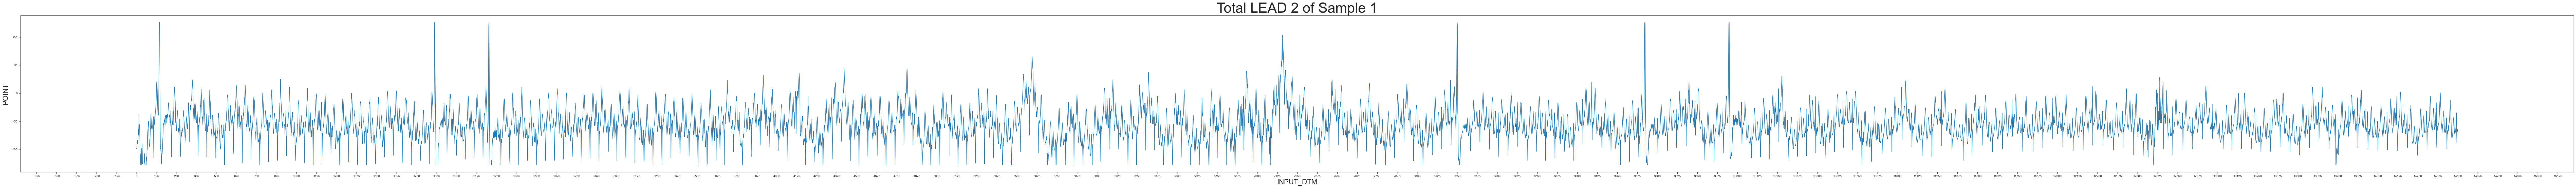

<Figure size 640x480 with 0 Axes>

In [28]:
# Plotting Lead 2

plt.figure(figsize=(130, 8))
sns.set_style('ticks')
p = sns.lineplot(x='INPUT_DTM', y='POINT', data=total_2)
p.set_title("Total LEAD 2 of Sample 1")
p.xaxis.set_major_locator(ticker.MultipleLocator(125))
p.xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":40,"axes.labelsize":20})  
plt.show()
plt.savefig(path+'Results/sample1_total_lead2.png', dpi = 800)

KeyboardInterrupt: 

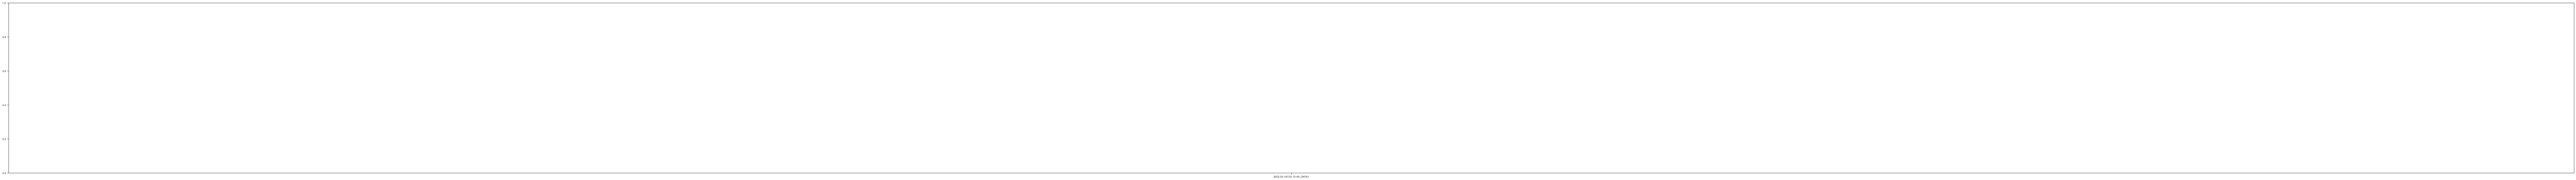

In [29]:
# Plotting Lead 3

plt.figure(figsize=(130, 8))
sns.set_style('ticks')
p = sns.lineplot(x='INPUT_DTM', y='POINT', data=total_3)
p.set_title("Total LEAD 3 of Sample 1")
p.xaxis.set_major_locator(ticker.MultipleLocator(125))
p.xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":40,"axes.labelsize":20})  
plt.show()
plt.savefig(path+'Results/sample1_total_lead3.png', dpi = 800)